In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random as ran
# MNIST input data
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("/tmp/data",one_hot=True)

/home/emmanuel/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Total Training Images in Dataset = (55000, 784)
--------------------------------------------------
x_train Examples Loaded = (55000, 784)
y_train Examples Loaded = (55000, 10)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


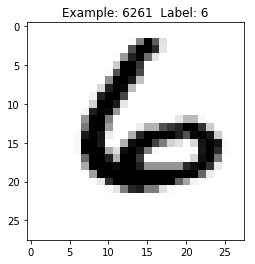

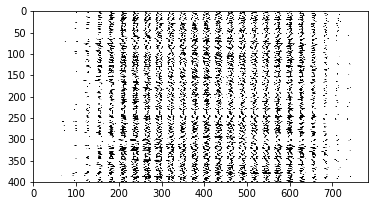

In [2]:
def train_size(num):
    print ('Total Training Images in Dataset = ' + str(mnist.train.images.shape))
    print ('--------------------------------------------------')
    x_train = mnist.train.images[:num,:]
    print ('x_train Examples Loaded = ' + str(x_train.shape))
    y_train = mnist.train.labels[:num,:]
    print ('y_train Examples Loaded = ' + str(y_train.shape))
    print('')
    return x_train, y_train

def test_size(num):
    print ('Total Test Examples in Dataset = ' + str(mnist.test.images.shape))
    print ('--------------------------------------------------')
    x_test = mnist.test.images[:num,:]
    print ('x_test Examples Loaded = ' + str(x_test.shape))
    y_test = mnist.test.labels[:num,:]
    print ('y_test Examples Loaded = ' + str(y_test.shape))
    return x_test, y_test

def display_digit(num):
    print(y_train[num])
    label = y_train[num].argmax(axis=0)
    image = x_train[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

def display_mult_flat(start, stop):
    images = x_train[start].reshape([1,784])
    for i in range(start+1,stop):
        images = np.concatenate((images, x_train[i].reshape([1,784])))
    plt.imshow(images, cmap=plt.get_cmap('gray_r'))
    plt.show()

x_train, y_train = train_size(55000)
display_digit(ran.randint(0, x_train.shape[0]))
display_mult_flat(0,400)

In [3]:
# Parameters
learning_rate=1e-4
training_iters=500
batch_size=128
display_step=10


In [4]:
# Network parameters
n_input=784
n_classes=10
dropout=0.85


In [5]:
# variables
x=tf.placeholder(tf.float32,[None,n_input])
y=tf.placeholder(tf.float32,[None,n_classes])
keep_prob=tf.placeholder(tf.float32)

In [6]:
# define helper conv
def conv2d(x,W,b,strides=1):
    x=tf.nn.conv2d(x,W,strides=[1,strides,strides,1],padding='SAME')
    x=tf.nn.bias_add(x,b)
    return tf.nn.relu(x)

In [7]:
# define helper max pool
def maxpool2d(x,k=2):
    return tf.nn.max_pool(x,ksize=[1,k,k,1],strides=[1,k,k,1],padding='SAME')

In [8]:
def convnet(x,weights,biases,dropout):
    # reshape the input picture
    x=tf.reshape(x,shape=[-1,28,28,1])
    #first convolution layer
    conv1=conv2d(x,weights['wc1'],biases['bc1'])
    #max pooling
    conv1=maxpool2d(conv1,k=2)
    #second convolution layer
    conv2=conv2d(conv1,weights['wc2'],biases['bc2'])
    #max pooling
    conv2=maxpool2d(conv2,k=2)
    #reshape conv2 to fully connected
    fc1=tf.reshape(conv2,[-1,weights['wd1'].get_shape().as_list()[0]])
    # fully connected layer
    fc1=tf.add(tf.matmul(fc1,weights['wd1']),biases['bd1'])
    fc1=tf.nn.relu(fc1)
    # dropout
    fc1=tf.nn.dropout(fc1,dropout)
    #output class prediction
    out=tf.add(tf.matmul(fc1,weights['out']),biases['out'])
    return out

In [9]:
# define weights
weights={
    #5x5 conv, 1 input, and 32 outputs
    'wc1':tf.Variable(tf.random_normal([5,5,1,32])),
    # 5x5 conv, 32 inputs, and 64 outputs
    'wc2':tf.Variable(tf.random_normal([5,5,32,64])),
    #fully connected 7*7*64 inputs, and 1024 outputs
    'wd1':tf.Variable(tf.random_normal([7*7*64,1024])),
    # 1024 inputs, 10 outputs
    'out':tf.Variable(tf.random_normal([1024,n_classes]))
}

In [10]:
#define biases
biases={
    'bc1':tf.Variable(tf.random_normal([32])),
    'bc2':tf.Variable(tf.random_normal([64])),
    'bd1':tf.Variable(tf.random_normal([1024])),
    'out':tf.Variable(tf.random_normal([n_classes]))
    
}

In [11]:
pred=convnet(x,weights,biases,keep_prob)
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y))
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
correct_prediction=tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
init=tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [ ]:
train_loss=[]
train_acc=[]
test_acc=[]
with tf.Session() as sess:
    sess.run(init)
    step=1
    while step<=training_iters:
        batch_x,batch_y=mnist.train.next_batch(batch_size)
        sess.run(optimizer,feed_dict={x:batch_x,y:batch_y,keep_prob:dropout})
        if step%display_step==0:
            loss_train,acc_train=sess.run([cost,accuracy],feed_dict={x:batch_x,y:batch_y,keep_prob:1.0})
            print ("Iter " + str(step) + ", Minibatch Loss= " + \
                  "{:.2f}".format(loss_train) + ", Training Accuracy= " + \
                  "{:.2f}".format(acc_train))
            
            # calculate accurate for 2048 mnist test images
            acc_test=sess.run(accuracy,feed_dict={x:mnist.test.images,y:mnist.test.labels, keep_prob:1.0})
            print("Testing Accuracy:" + \
               "{:.2f}".format(acc_train))
    
            train_loss.append(loss_train)
            train_acc.append(acc_train)
            test_acc.append(acc_test)
        step+=1
        

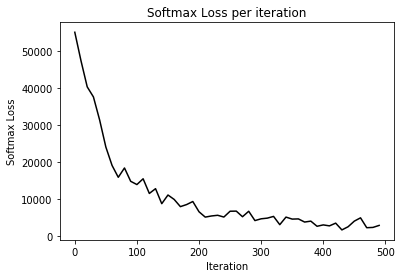

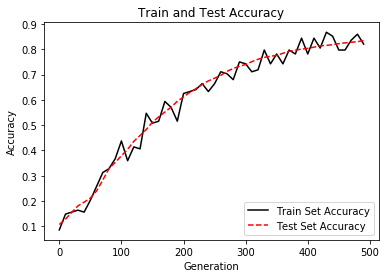

In [37]:
eval_indices = range(0, training_iters, display_step)
# Plot loss over time
plt.plot(eval_indices, train_loss, 'k-')
plt.title('Softmax Loss per iteration')
plt.xlabel('Iteration')
plt.ylabel('Softmax Loss')
plt.show()
# Plot train and test accuracy
plt.plot(eval_indices, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()